Experiments and ideas for experiments, 21 September 2022. 

In [1]:
import numpy as np
from typing import List

import torch
import math
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import argparse
from tqdm import tqdm

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

from source import *

Running on: cpu


# Defining StepReLU

In [2]:
# Lambda version

stepReLU1 = lambda v : int(torch.linalg.norm(v) >=1)*v

In [3]:
# Version with a specified cutoff value

def stepReLU(v, cutoff):
    r = torch.linalg.norm(v)
    if r < cutoff:
        return torch.zeros(np.shape(v)) 
    return v

In [4]:
# Version for the eta in the definition of a radial rescaling activation

def stepReLU_eta(r):
    if r.shape == torch.Size([]):
        if r < 1:
            return 1e-6
        return r
    else:
        for i in range(len(r)):
            if r[i] < 1:
                r[i] = 1e-6
        return r

# Examples

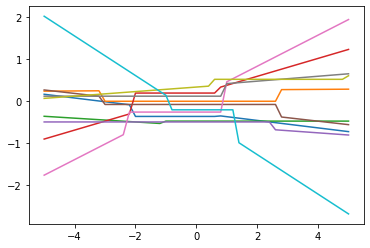

In [5]:
# Examples of stepReLU target networks
for _ in range(10):
    target_radnet = RadNet(eta=stepReLU_eta, dims=[1,2,3,1], has_bias=False)
    x_target = torch.tensor([-5.0 + i/5 for i in range(51)]).unsqueeze(1)
    y_target = torch.zeros(x_target.shape)
    for i in range(x_target.shape[0]):
        y_target[i] = target_radnet(x_target[i])
    plt.plot(x_target.detach().numpy(),y_target.detach().numpy())

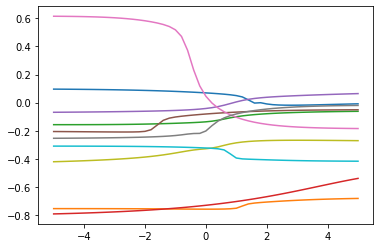

In [6]:
# Examples of sigmoid target networks
for _ in range(10):
    target_radnet = RadNet(eta=torch.sigmoid, dims=[1,2,3,1], has_bias=False)
    x_target = torch.tensor([-5.0 + i/5 for i in range(51)]).unsqueeze(1)
    y_target = torch.zeros(x_target.shape)
    for i in range(x_target.shape[0]):
        y_target[i] = target_radnet(x_target[i])
    plt.plot(x_target.detach().numpy(),y_target.detach().numpy())

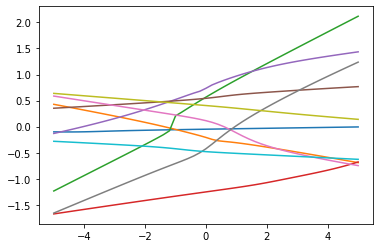

In [7]:
# Examples of ReLU target networks (with bias)
for _ in range(10):
    target_radnet = RadNet(eta=F.relu, dims=[1,2,3,1], has_bias=True)
    x_target = torch.tensor([-5.0 + i/5 for i in range(51)]).unsqueeze(1)
    y_target = torch.zeros(x_target.shape)
    for i in range(x_target.shape[0]):
        y_target[i] = target_radnet(x_target[i])
    plt.plot(x_target.detach().numpy(),y_target.detach().numpy())

Next steps:

* Have a baseline MLP with several different activation functions. Try to fit each baseline to the target radial neural network (also with different activations).

* Step-ReLU networks.

* Vary parameters of the radial nn a lot. Try different input and output dimensions. 

Questions:

1. Does the radial NN converge to the target faster? Need to have the same optimizer to have a fair comparison.

2. Generalization. Train / test data split. Compare convergence over the test set. 

3. Vary the amount of train data. Is a radial nn able to fit well in a low-data regime. 

4. If you use an overparametrized radial NN to fit a reduced radial NN, is the reduction of the trained overparametrized model equal to the reduced target radial NN.

Later:

* Can we try a "natural" dataset? Maybe flow cytometry (https://en.wikipedia.org/wiki/Flow_cytometry).


# Use a radial neural network to learn another radial neural network

In [8]:
## Approximate stepReLU with stepReLU

In [9]:
def approximate(eta_target, eta_approx, dims_target, dims_approx, has_bias, n_epochs, learning_rate):
    
    # Target network
    target_radnet = RadNet(eta=eta_target, dims=dims_target, has_bias=has_bias)
    x_target = torch.tensor([-5.0 + i/5 for i in range(51)]).unsqueeze(1)
    y_target = target_radnet(x_target)
    x_target = x_target.detach()
    y_target = y_target.detach()
    plt.plot(x_target,y_target)
    
    # Approximator network, to be trained
    approx_radnet = RadNet(eta=eta_approx, dims=dims_approx, has_bias=has_bias)
    
    # Training loop
    model_trained, model_losses = training_loop(
        n_epochs = n_epochs, 
        learning_rate = learning_rate,
        model = approx_radnet,
        params = list(approx_radnet.parameters()),
        x_train = x_target,
        y_train = y_target,
        verbose=True)
    plt.plot(x_target, y_target)
    plt.plot(x_target, model_trained(x_target).detach())
    
    return model_losses[-1].detach()

Epoch 1, Loss 0.374524
Epoch 500, Loss 0.006366
Epoch 1000, Loss 0.006366
Epoch 1500, Loss 0.006366
Epoch 2000, Loss 0.006366
Epoch 2500, Loss 0.006366
Epoch 3000, Loss 0.006366
Epoch 3500, Loss 0.006366
Epoch 4000, Loss 0.006366
Epoch 4500, Loss 0.006366
Epoch 5000, Loss 0.006366


tensor(0.0064)

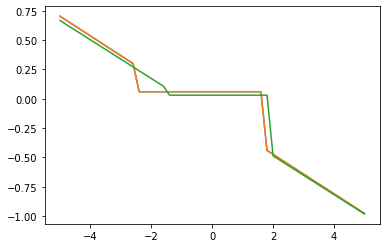

In [10]:
approximate(
    eta_target=stepReLU_eta,
    eta_approx = stepReLU_eta,
    dims_target = [1,2,3,1],
    dims_approx = [1,2,3,1],
    has_bias = False,
    n_epochs = 5000,
    learning_rate = 0.1)

Epoch 1, Loss 0.119954
Epoch 500, Loss 0.000982
Epoch 1000, Loss 0.000573
Epoch 1500, Loss 0.000480
Epoch 2000, Loss 0.000431
Epoch 2500, Loss 0.000395
Epoch 3000, Loss 0.000366
Epoch 3500, Loss 0.000340
Epoch 4000, Loss 0.000317
Epoch 4500, Loss 0.000295
Epoch 5000, Loss 0.000274


tensor(0.0003)

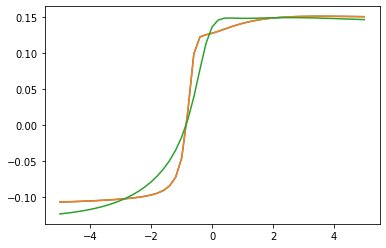

In [11]:
approximate(
    eta_target=torch.sigmoid,
    eta_approx = torch.sigmoid,
    dims_target = [1,2,3,1],
    dims_approx = [1,2,3,1],
    has_bias = False,
    n_epochs = 5000,
    learning_rate = 0.1)

Epoch 1, Loss 1.626257
Epoch 500, Loss 0.000403
Epoch 1000, Loss 0.000369
Epoch 1500, Loss 0.000345
Epoch 2000, Loss 0.000327
Epoch 2500, Loss 0.000310
Epoch 3000, Loss 0.000289
Epoch 3500, Loss 0.000257
Epoch 4000, Loss 0.000204
Epoch 4500, Loss 0.000138
Epoch 5000, Loss 0.000094


tensor(9.3753e-05)

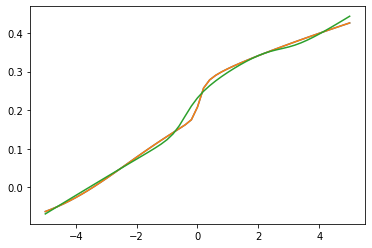

In [12]:
approximate(
    eta_target= F.relu,
    eta_approx = F.relu,
    dims_target = [1,2,3,1],
    dims_approx = [1,2,3,1],
    has_bias = True,
    n_epochs = 5000,
    learning_rate = 0.1)

Epoch 1, Loss 0.877987
Epoch 500, Loss 0.001349
Epoch 1000, Loss 0.001235
Epoch 1500, Loss 0.001234
Epoch 2000, Loss 0.001234
Epoch 2500, Loss 0.001234
Epoch 3000, Loss 0.001234
Epoch 3500, Loss 0.001234
Epoch 4000, Loss 0.001234
Epoch 4500, Loss 0.001234
Epoch 5000, Loss 0.001234


tensor(0.0012)

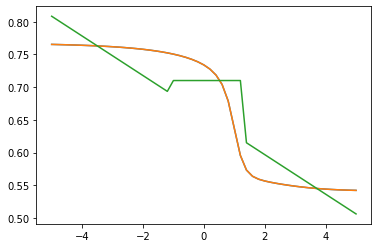

In [13]:
approximate(
    eta_target=torch.sigmoid,
    eta_approx = stepReLU_eta,
    dims_target = [1,2,3,1],
    dims_approx = [1,2,3,1],
    has_bias = False,
    n_epochs = 5000,
    learning_rate = 0.1)

# Baseline ReLU network

In [14]:
def build_net():
    return torch.nn.Sequential(
        torch.nn.Linear(64, 32),
        torch.nn.ReLU(),
        torch.nn.Linear(32, 10)
    )
net = build_net()
print(net)

Sequential(
  (0): Linear(in_features=64, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=10, bias=True)
)


# Use a radial neural network to learn MNIST

This page is useful: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

In [59]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

In [60]:
train_dataloader = DataLoader(training_data, batch_size=256, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=256, shuffle=True)

Feature batch shape: torch.Size([256, 1, 28, 28])
Labels batch shape: torch.Size([256])


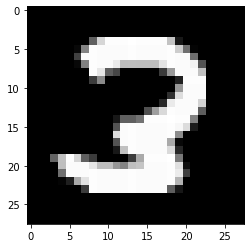

Label: 3


In [61]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

torch.Size([27, 1, 28, 28])


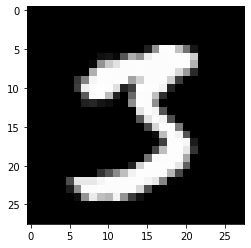

In [101]:
threes = train_features[train_labels == 3]
print(threes.shape)
plt.imshow(threes[2].squeeze(), cmap="gray")

In [102]:
d=28**2
m= 100 # number of samples
u = np.random.multivariate_normal(np.zeros(d),np.eye(d),m)  # an array of d normally distributed random variables
norm=np.sum(u**2, axis = 1) **(0.5)
norm = norm.reshape(m,1)
r = np.random.uniform(size=m)**(1.0/d)
r = r.reshape(m,1)
noise= r*u/norm
# plt.scatter(x[:,0], x[:,1])
noise.shape

(100, 784)

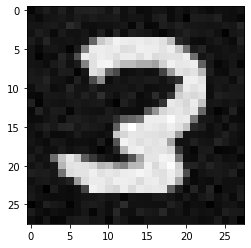

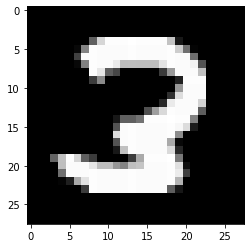

In [103]:
img = threes[0].reshape(1,d)
noisy_img = torch.tensor(noise) + img
noisy_img.shape

plt.imshow(noisy_img[0].reshape(28,28), cmap="gray")
plt.show()
plt.imshow(img.reshape(28,28), cmap="gray")
plt.show()

In [108]:
# Iterate over the images in threes (can broadcast instead of for loops)
# Apply labels (see code below)
# 

In [110]:
# Code for five original samples, each repeated m times
m = 2
np.eye(5).reshape(1,5,5).repeat(m, axis=0).reshape(m*5,5)

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]])

In [65]:
train_features_flat = train_features.flatten(1)
train_features_flat.shape

torch.Size([256, 784])

In [19]:
radnet = RadNet(eta=torch.sigmoid, dims=[28*28,2,1], has_bias=False)

In [20]:
model_trained, model_losses = training_loop(
    n_epochs = 5000, 
    learning_rate = 0.1,
    model = radnet,
    params = list(radnet.parameters()),
    x_train = train_features_flat,
    y_train = train_labels,
    verbose=True)

Epoch 1, Loss 35.838188
Epoch 500, Loss 7.069355
Epoch 1000, Loss 7.069352
Epoch 1500, Loss 7.069350
Epoch 2000, Loss 7.069348
Epoch 2500, Loss 7.069347
Epoch 3000, Loss 7.069346
Epoch 3500, Loss 7.069345
Epoch 4000, Loss 7.069344
Epoch 4500, Loss 7.069344
Epoch 5000, Loss 7.069343


# Generate MNIST with noise around samples

In [27]:
d=2
m= 100 # number of samples
u = np.random.normal(0,1,d)  # an array of d normally distributed random variables
norm=np.sum(u**2) **(0.5)
r = np.random.uniform()**(1.0/d)
x= r*u/norm
x

array([0.16125975, 0.75156835])

In [58]:
d=28^2
m= 100 # number of samples
u = np.random.multivariate_normal(np.zeros(d),np.eye(d),m)  # an array of d normally distributed random variables
norm=np.sum(u**2, axis = 1) **(0.5)
norm = norm.reshape(m,1)
r = np.random.uniform(size=m)**(1.0/d)
r = r.reshape(m,1)
x= r*u/norm
# plt.scatter(x[:,0], x[:,1])
x

array([[-0.12578676,  0.17643614, -0.17167848, ..., -0.04595429,
        -0.0410824 ,  0.05490579],
       [-0.26722603,  0.02494061, -0.14609277, ..., -0.07273858,
        -0.12299998, -0.04242949],
       [-0.1236768 ,  0.26463872,  0.20641185, ...,  0.4461635 ,
        -0.08695898,  0.02144739],
       ...,
       [-0.08155094, -0.30196019, -0.04270661, ..., -0.08556742,
        -0.32106189,  0.23328026],
       [-0.01069922, -0.31929118, -0.1307041 , ..., -0.09444498,
        -0.17703414,  0.19835983],
       [ 0.14593334, -0.04809112, -0.13186126, ...,  0.04237002,
         0.05612778, -0.03499641]])

# Scraps

In [21]:
x_synth = torch.tensor([-3.0 + i/20 for i in range(121)]).unsqueeze(1)
y_synth = torch.zeros(x_synth.shape)
for i in range(x_synth.shape[0]):
    y_synth[i] = torch.exp(-(x_synth[i])**2)

#################################
## Instantiate a radial neural network
#################################

radnet = RadNet(eta=torch.sigmoid, dims=[1,2,3,1], has_bias=False)
orig_dims = radnet.dims
reduce_dims = radnet.dims_red

#################################
## Train the reduced model using ordinary gradient descent
#################################

model_trained, model_losses = training_loop(
    n_epochs = 500, 
    learning_rate = 0.01,
    model = radnet,
    params = list(radnet.parameters()),
    x_train = x_synth,
    y_train = y_synth,
    verbose=True)

Epoch 1, Loss 0.523310
Epoch 500, Loss 0.120308
